# **Demand Forecasting Optimization for Corporation Favorita A Time Series Regression ML Approach**

Business Understanding

#### Objective:
Corporation Favorita wants to ensure they always have the right quantity of products in stock. We need to build machine learning models to forecast the demand for products in various locations to optimize inventory management.

#### Key Analytical Questions:
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices, and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect?
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them)?
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales?

#### Hypothesis:
1. Null Hypothesis (H0): Promotions do not have a significant impact on sales.
   Alternative Hypothesis (H1): Promotions have a significant impact on sales.
2. Null Hypothesis (H0): Oil prices do not significantly impact sales.
   Alternative Hypothesis (H1): Oil prices significantly impact sales.

## **Importing Necessary packages**

In [1]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy import stats
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

## **Data Collection**

In [2]:
# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Creating a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connecting to the server
connection = pyodbc.connect(connection_string)

Loading data from the database

In [3]:
# Loading Oil dataset
oil = pd.read_sql_query("SELECT * FROM dbo.oil", connection)

# Saving the DataFrame to a CSV file
oil.to_csv('data/oil.csv', index=False)

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [4]:
# Loading holidays_events dataset
holidays_events = pd.read_sql_query(
    "SELECT * FROM dbo.holidays_events", connection)

# Saving the DataFrame to a CSV file
holidays_events.to_csv('data/holidays_events.csv', index=False)

holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# Loading stores dataset
stores = pd.read_sql_query("SELECT * FROM dbo.stores", connection)

# Saving the DataFrame to a CSV file
stores.to_csv('data/stores.csv', index=False)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
train = pd.read_csv('Data/train.csv')

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
test = pd.read_csv('Data/test.csv')

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [8]:
transactions = pd.read_csv('Data/transactions.csv')

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
sample_submission = pd.read_csv('Data/sample_submission.csv')

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## **Data Cleaning and Preparation**

1. Missing Values Handling

In [10]:
# Check for missing values in each dataset
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()
missing_values_transactions = transactions.isnull().sum()
missing_values_stores = stores.isnull().sum()
missing_values_oil = oil.isnull().sum()
missing_values_holidays_events = holidays_events.isnull().sum()
missing_values_sample_submission = sample_submission.isnull().sum()

missing_values_train, missing_values_test, missing_values_transactions, missing_values_stores, missing_values_oil, missing_values_holidays_events, missing_values_sample_submission

(id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 family         0
 onpromotion    0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64,
 store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
 date           0
 dcoilwtico    43
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
 id       0
 sales    0
 dtype: int64)

In [11]:
# Fill missing values in the oil dataset using forward fill
oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Verify that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    1
dtype: int64

In [12]:
# Fill the remaining missing value using backward fill
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verify that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    0
dtype: int64

2. Data Types Correction

In [14]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

3. Merging Datasets

In [23]:
# Merge train dataset with transactions, stores, oil, and holidays_events
train_merged = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(holidays_events, on='date', how='left')

# Repeat the same for the test dataset
test_merged = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test_merged = test_merged.merge(stores, on='store_nbr', how='left')
test_merged = test_merged.merge(oil, on='date', how='left')
test_merged = test_merged.merge(holidays_events, on='date', how='left')

4. Creating Date Features

In [24]:
# Create additional features from the date
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month
train_merged['day'] = train_merged['date'].dt.day
train_merged['dayofweek'] = train_merged['date'].dt.dayofweek

test_merged['year'] = test_merged['date'].dt.year
test_merged['month'] = test_merged['date'].dt.month
test_merged['day'] = test_merged['date'].dt.day
test_merged['dayofweek'] = test_merged['date'].dt.dayofweek

5. Handling Categorical Variables

In [31]:
# Correctly rename columns before one-hot encoding
train_merged.rename(columns={'type_x': 'store_type',
                    'type_y': 'holiday_type'}, inplace=True)
test_merged.rename(columns={'type_x': 'store_type',
                   'type_y': 'holiday_type'}, inplace=True)

# Convert categorical variables to numeric using one-hot encoding
categorical_columns = ['family', 'city', 'state', 'store_type',
                       'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
train_final = pd.get_dummies(
    train_merged, columns=categorical_columns, drop_first=True)
test_final = pd.get_dummies(
    test_merged, columns=categorical_columns, drop_first=True)

## **Exploratory Data Analysis (EDA)**

### Sales trends over time

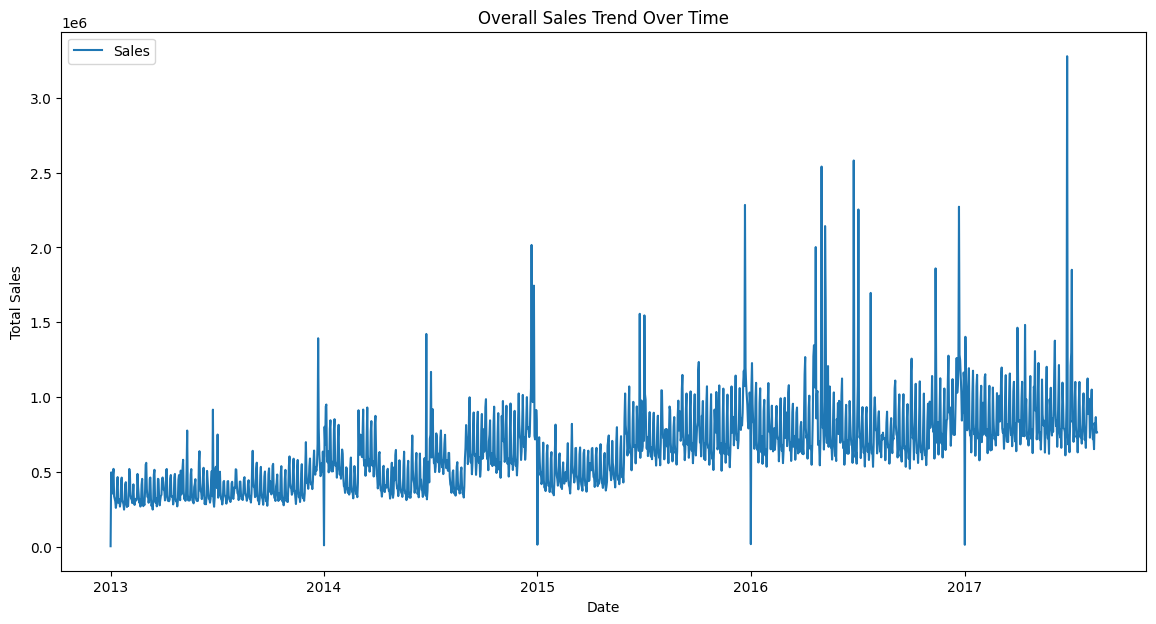

In [33]:
# Aggregate sales by date to see the overall trend
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# Plot the overall sales trend
plt.figure(figsize=(14, 7))
plt.plot(sales_trend['date'], sales_trend['sales'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Overall Sales Trend Over Time')
plt.legend()
plt.show()

### Seasonality and Monthly Sales Patterns

<Figure size 1400x700 with 0 Axes>

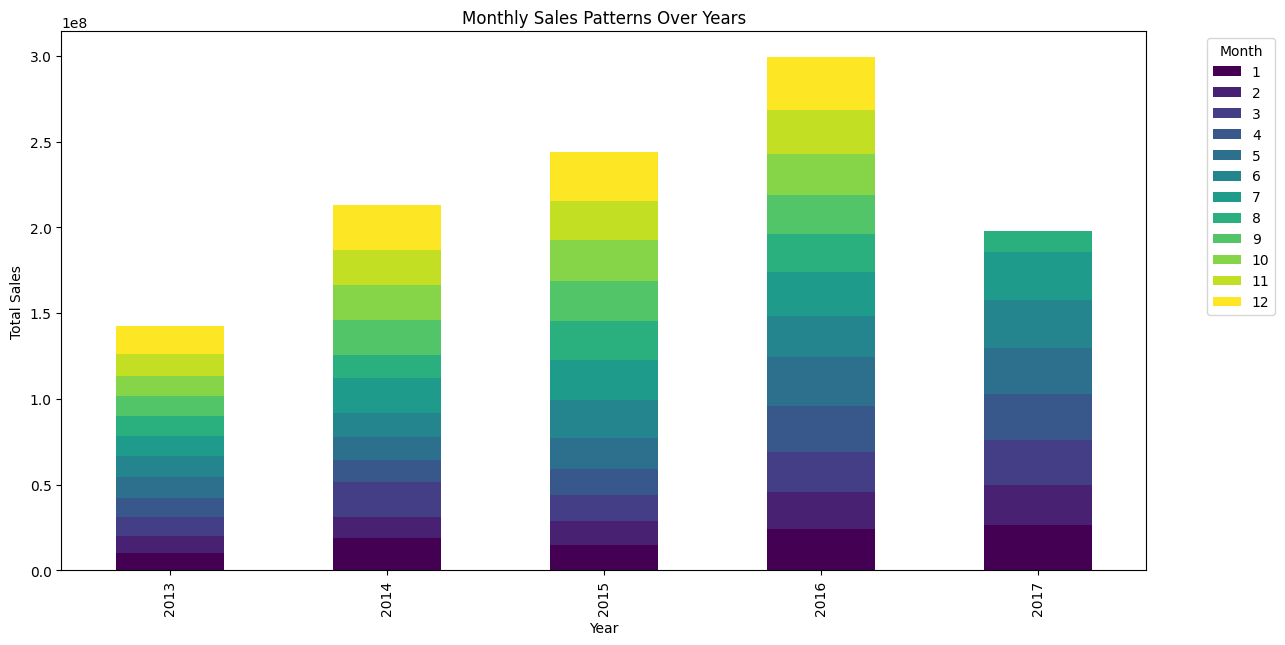

In [34]:
# Aggregate sales by month and year
monthly_sales = train_merged.groupby(['year', 'month'])[
    'sales'].sum().unstack()

# Plot monthly sales patterns
plt.figure(figsize=(14, 7))
monthly_sales.plot(kind='bar', stacked=True,
                   colormap='viridis', figsize=(14, 7))
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Patterns Over Years')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Sales Distribution Across Stores and Product Families

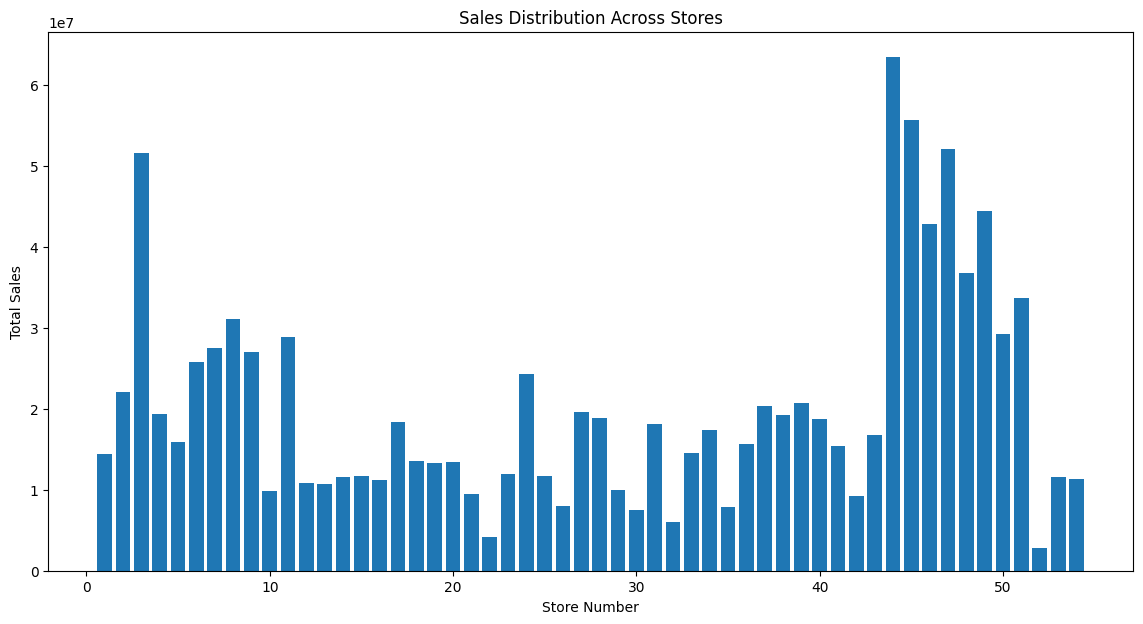

In [35]:
# Aggregate sales by store and product family
store_sales = train_merged.groupby('store_nbr')['sales'].sum(
).sort_values(ascending=False).reset_index()
family_sales = train_merged.groupby(
    'family')['sales'].sum().sort_values(ascending=False).reset_index()

# Plot sales distribution across stores
plt.figure(figsize=(14, 7))
plt.bar(store_sales['store_nbr'], store_sales['sales'])
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Sales Distribution Across Stores')
plt.show()

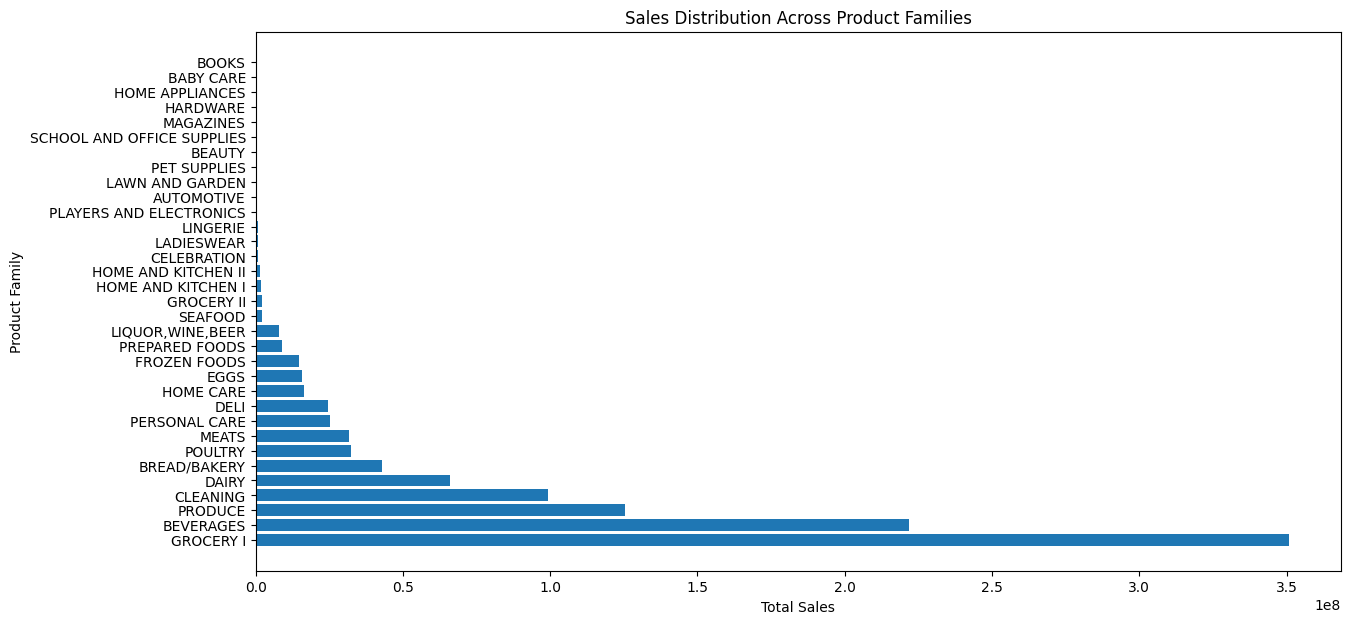

In [37]:
# Plot sales distribution across product families
plt.figure(figsize=(14, 7))
plt.barh(family_sales['family'], family_sales['sales'])
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.title('Sales Distribution Across Product Families')
plt.show()

### Impact of Promotions

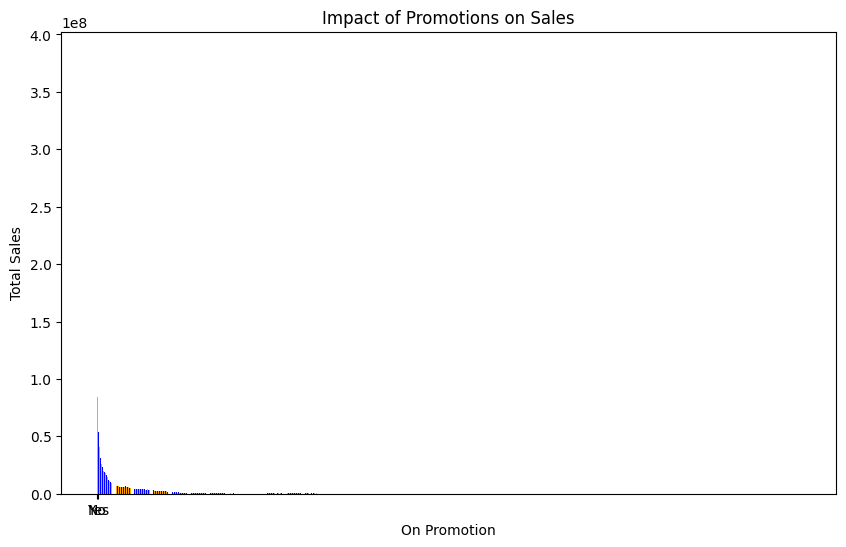

In [38]:
# Aggregate sales by promotion status
promotion_sales = train_merged.groupby(
    'onpromotion')['sales'].sum().reset_index()

# Plot impact of promotions on sales
plt.figure(figsize=(10, 6))
plt.bar(promotion_sales['onpromotion'],
        promotion_sales['sales'], color=['blue', 'orange'])
plt.xlabel('On Promotion')
plt.ylabel('Total Sales')
plt.title('Impact of Promotions on Sales')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

### Impact of Oil Prices

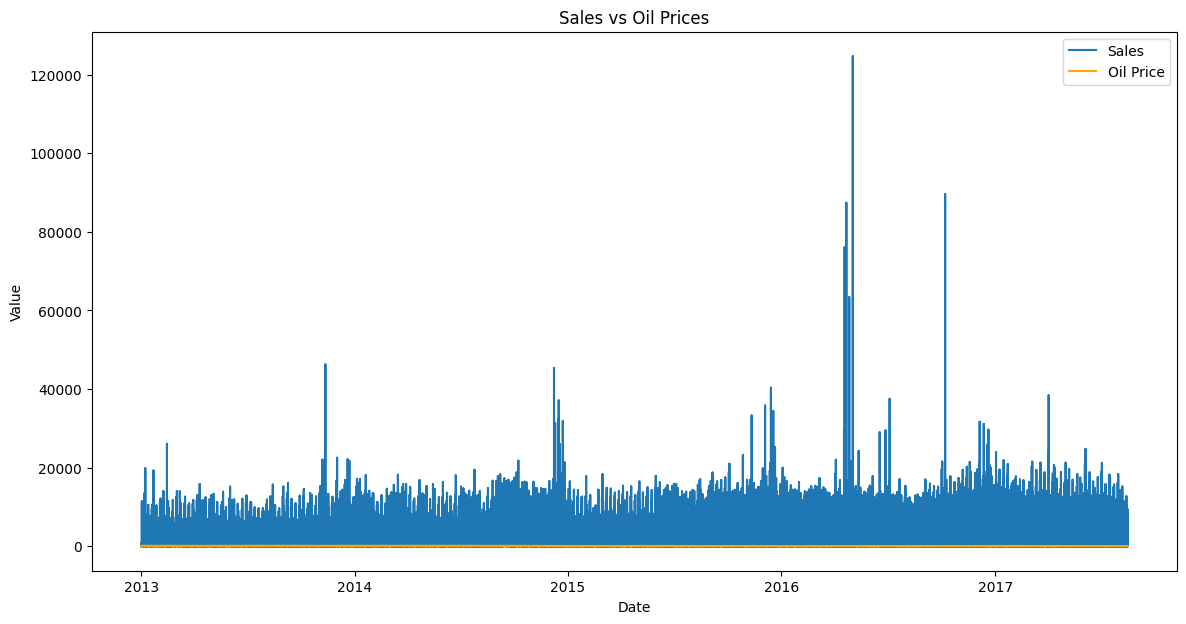

In [40]:
# Plot sales versus oil prices
plt.figure(figsize=(14, 7))
plt.plot(train_merged['date'], train_merged['sales'], label='Sales')
plt.plot(train_merged['date'], train_merged['dcoilwtico'],
         label='Oil Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sales vs Oil Prices')
plt.legend()
plt.show()

### Impact of Holidays

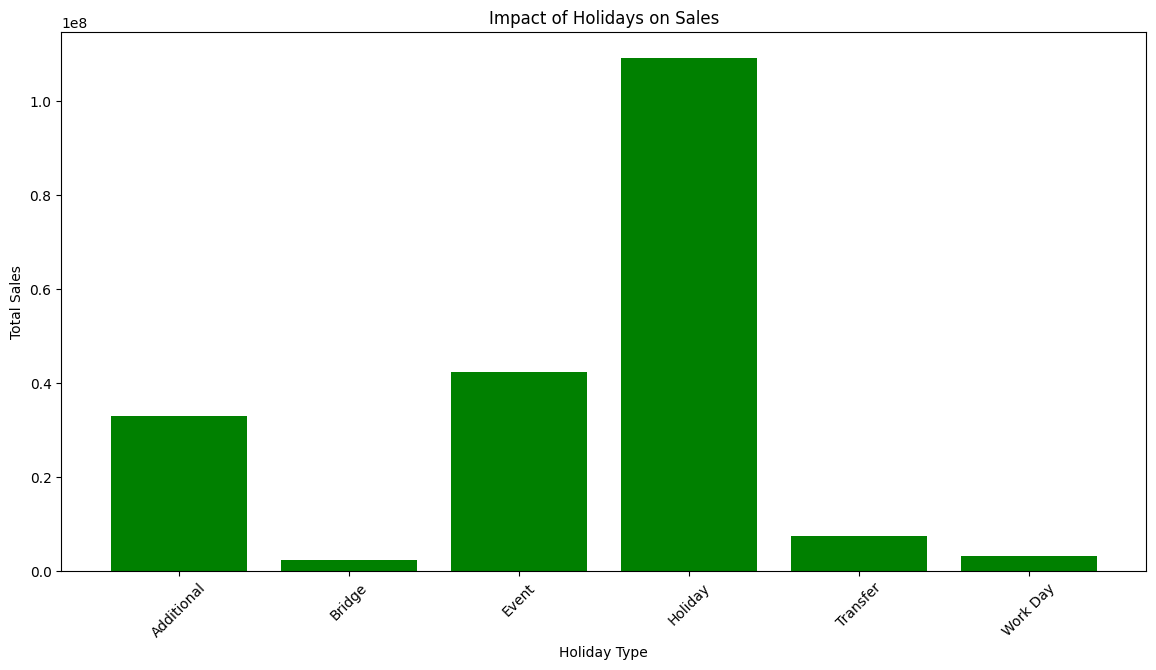

In [41]:
# Aggregate sales by holiday status
holiday_sales = train_merged.groupby(
    'holiday_type')['sales'].sum().reset_index()

# Plot impact of holidays on sales
plt.figure(figsize=(14, 7))
plt.bar(holiday_sales['holiday_type'], holiday_sales['sales'], color='green')
plt.xlabel('Holiday Type')
plt.ylabel('Total Sales')
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
plt.show()

## **Hypothesis Testing**

In [42]:
from scipy.stats import ttest_ind

# Separate sales data for promoted and non-promoted products
promoted_sales = train_merged[train_merged['onpromotion'] > 0]['sales']
non_promoted_sales = train_merged[train_merged['onpromotion'] == 0]['sales']

# Perform t-test
t_stat, p_value = ttest_ind(promoted_sales, non_promoted_sales)

t_stat, p_value

(669.9966792269075, 0.0)

In [44]:
# Fill missing values in the oil prices
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
train_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verify there are no more missing values
train_merged['dcoilwtico'].isnull().sum()

0

In [45]:
from scipy.stats import pearsonr

# Extract sales and oil prices
sales = train_merged['sales']
oil_prices = train_merged['dcoilwtico']

# Perform Pearson correlation
correlation, p_value = pearsonr(sales, oil_prices)

correlation, p_value

(-0.07542992345232422, 0.0)